In [1]:
import numpy as np
import scipy.linalg
from scipy.stats import ortho_group
from scipy.io import loadmat
from localizer import Localizer
import psi4
from iodata import load_one, dump_one
import electrostatics as esp
# import nglview as nv
import random

#https://github.com/molmod/molmod
from molmod.units import angstrom, debye

import matplotlib.pyplot as plt
import json

#importing the QM7 database
# data = dict(loadmat('../data/molecule_geometries/qm7.mat'))
# Z = data['Z'] # numbers
# R = data['R']/angstrom # positions in angstrom

#importing the centered QM7 database
# Z = np.load('../data/molecule_geometries/qm7_Z.npy')
# R = np.load('../data/molecule_geometries/qm7_R_centered.npy')

#final dataset
Z = np.load('../data/molecule_geometries/benchmarking_dataset_Z.npy')
R = np.load('../data/molecule_geometries/benchmarking_dataset_R.npy')
qm7_idxs = np.load('../data/molecule_geometries/benchmark_idxs.npy')

# Molecule order: H2O,CO2,HCN,Acetonitrile,H2SO4,Benzene,Diborane
numbers = np.load('../data/molecule_geometries/nuclei_numbers.npy')
positions = np.load('../data/molecule_geometries/positions.npy')

# Load already existing geomtries
R_opt = np.load('../data/molecule_geometries/optimized_geometries.npy', allow_pickle=True).tolist()
Z_opt = np.load('../data/molecule_geometries/optimized_geometries_nuclei.npy', allow_pickle=True).tolist()

In [2]:
idx = 6
loc = Localizer(Z[idx], R[idx], index=qm7_idxs[idx], lot='scf',
                check_import=False, cores=4, memory=6e+09)

generating data for: 0126_C5H6
Psi4 Model initiated with method scf and basis set 6-311ppg_d_p_
writing out psi4 data for molecule: 0126_C5H6


In [27]:
loc.set_scheme('FB_p')

In [3]:
loc.optimize_line_search(nsteps=500, psi4_guess=False, save_iteration=100)

Optimizing cost function: FB
Convergence: norm of riemann gradient below 10^-5


True

In [9]:
loc.write_centers()

Geometry data written to: ../data/xyz_files/local_runs/FB/0126_C5H6_FB_6-311ppg_d_p__b3lyp.xyz


Text(0, 0.5, '$norm(\\mathbf{G}_k)$')

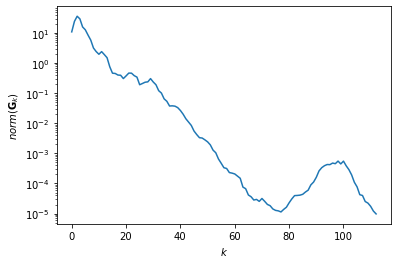

In [4]:
plt.plot(loc.conv_hist[np.where(loc.conv_hist != 0.)])
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$norm(\mathbf{G}_k)$')
# plt.savefig('norm_GCPR')

In [17]:
loc.compare_quadrupole()

array([[-0.58736809, -0.27731464,  0.0062465 ],
       [-0.27731464,  0.14917932,  0.00377698],
       [ 0.0062465 ,  0.00377698,  0.43818876]])

In [18]:
loc.total_quadrupole

array([[ 0.75648978, -0.0630479 ,  0.00107245],
       [-0.0630479 , -0.0138356 , -0.01727422],
       [ 0.00107245, -0.01727422, -0.74265418]])

In [24]:
loc.total_loc_quadrupole

array([[ 1.63673132,  0.32623312, -0.01275101],
       [ 0.32623312, -0.26476198, -0.02568964],
       [-0.01275101, -0.02568964, -1.37196934]])

In [34]:
loc.V4_cost(loc.W)

DeviceArray(-1.48444433e-05, dtype=float64)

In [15]:
loc.FB_cost(loc.W)

Buffer(158.26567261, dtype=float64)

In [11]:
loc.write_centers()

Geometry data written to: ../data/xyz_files/local_runs/V4/0342_NC5H7_V4_6-311ppg_d_p__scf.xyz


In [5]:
loc.write_orbitals()

## Second attempt using molden files

In [ ]:
psi4.molden(loc.model.wavefunction,'methane.molden')

In [ ]:
methane = load_one('methane.molden')
methane_mo = methane.mo
molden_C_occ = methane_mo.coeffs
molden_C_occ[:,:loc.N_occ] = loc.L_occ
methane_mo.coeffs = molden_C_occ
dump_one(methane, 'methane_test.fchk')

## Plotting the polynomial approximation

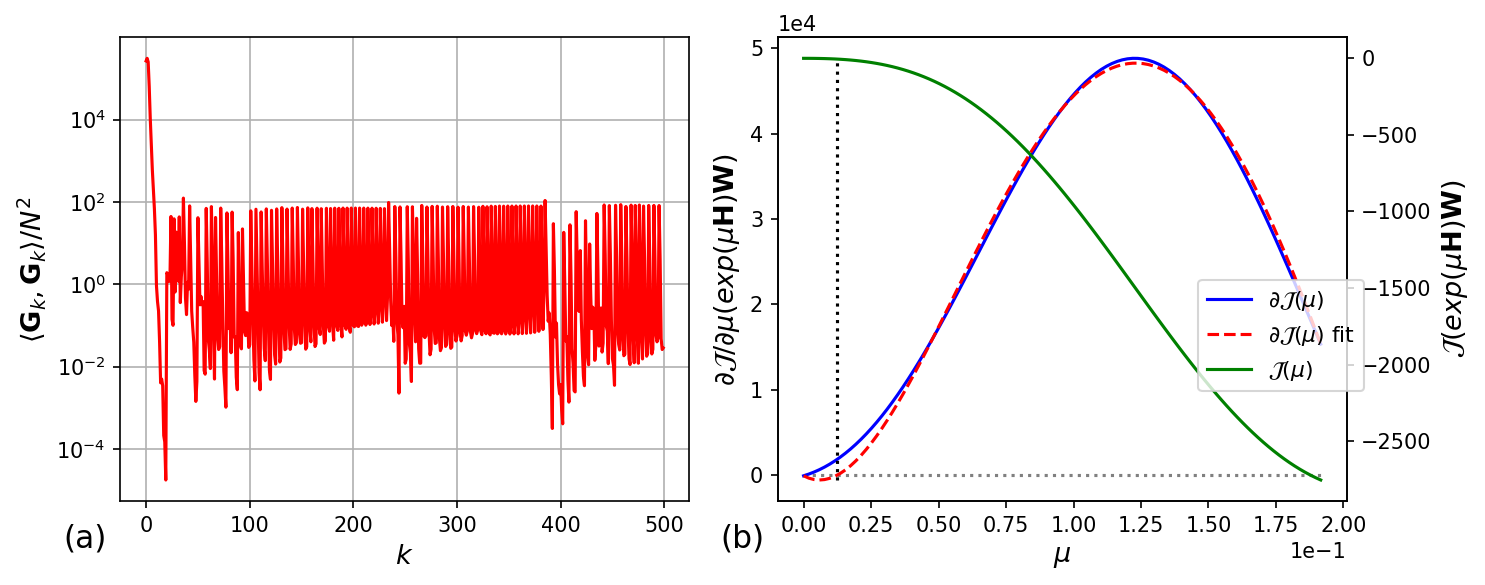

In [76]:
mu = np.linspace(0,loc.iteration_hist['MuMax'], 100)
dJ_mu = np.zeros((100))
J_mu = np.zeros((100))

H = loc.iteration_hist['H']
W = loc.iteration_hist['W']

for i in range(100):
    R = scipy.linalg.expm(mu[i]*H)
    J_mu[i] = np.array(loc.cost_function(np.dot(R,W)))
    inter_grad = np.array(loc.cost_grad(np.dot(R,W)))
    dJ_mu[i] = -2*np.einsum('ij,kj,lk,il',inter_grad, W, R, H)

dJ_mu_fit = np.polynomial.polynomial.polyval(mu, np.flip(loc.iteration_hist['PolyCoeffs']))

fig, ax = plt.subplots(1, 2, figsize=(10,4), squeeze=False, dpi=150, tight_layout=True)

ax1 = ax[0][0]
ax = ax[0][1]

ax1.plot(loc.conv_hist[np.where(loc.conv_hist != 0.)], color='r')
ax1.set_yscale('log')
ax1.set_xlabel('$k$', fontsize=13)
ax1.set_ylabel(r'$\langle\mathbf{G}_k,\mathbf{G}_k\rangle/N^2$', fontsize=13)
ax1.grid()
ax1.text(-0.1, -0.1, '(a)', transform=ax1.transAxes, size=15)

lns1 = ax.plot(mu, dJ_mu, color='b', label='$\partial\mathcal{J}(\mu)$')
lns2 = ax.plot(mu, dJ_mu_fit, linestyle='--', color='r', label='$\partial\mathcal{J}(\mu)$ fit')
ax.hlines(0, np.min(mu), np.max(mu), linestyle='dotted', color='gray')
ax.ticklabel_format(axis='both', style='scientific', scilimits=(0,0))
ax.set_ylabel('$\partial \mathcal{J}/\partial \mu (exp(\mu\mathbf{H})\mathbf{W})$', fontsize=13)
ax.set_xlabel('$\mu$', fontsize=13)
# ax.legend()

ax2 = ax.twinx()
lns3 = ax2.plot(mu, J_mu, color='g', label='$\mathcal{J}(\mu)$')
ax2.vlines(np.real(loc.iteration_hist['Root']), np.min(J_mu), np.max(J_mu), linestyle='dotted', color='k')
ax2.set_ylabel('$\mathcal{J}(exp(\mu\mathbf{H})\mathbf{W})$', fontsize=13)
ax2.text(-0.1, -0.1, '(b)', transform=ax2.transAxes, size=15)

leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
# leg = ax2.legend(leg, labs, loc='lower right', framealpha=1, facecolor='white')
leg = ax2.legend(leg, labs, bbox_to_anchor=(0.55, 0., 0.5, 0.5),fontsize=10.5)
# ax2.set_zorder(100)
# ax.legend(leg, labs, loc='upper left', bbox_to_anchor=(1.1, 1.))
# ax2.legend()
# plt.grid()
# print(loc.iteration_hist['Root'])

# plt.savefig('../data/figures/plots/step_size_badfit3', dpi=300)

## Algorithm benchmarking

In [80]:
conv_hist = []
names = []
colors = ['r','b','g','y','k']
for i in [0,4,120,1160,1200]:
    loc = Localizer(Z[i], R[i], index=i, check_import=True)
    loc.optimize_line_search()
    conv_hist.append(loc.conv_hist[np.where(loc.conv_hist != 0.)])
    names.append(loc.generate_molname(scheme_name=False)[5:])

Imported data for: 0000_CH4
Optimizing cost function: FB
Convergence: norm of riemann gradient below 10^-5
Imported data for: 0004_OC2H6
Optimizing cost function: FB
Convergence: norm of riemann gradient below 10^-5
Imported data for: 0120_SC4H4
Optimizing cost function: FB
Convergence: norm of riemann gradient below 10^-5
Imported data for: 1160_SO2C3H6
Optimizing cost function: FB
Convergence: norm of riemann gradient below 10^-5
Imported data for: 1200_NC6H15
Optimizing cost function: FB
Convergence: norm of riemann gradient below 10^-5


In [81]:
# %matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(6,4), squeeze=False, dpi=200, tight_layout=True)
ax = ax[0,0]

for i in range(len(names)):
    ax.plot(conv_hist[i], color=colors[i], label=names[i])
ax.set_yscale('log')
ax.set_xlabel('$k$')
ax.set_ylabel(r'$\langle\mathbf{G}_k,\mathbf{G}_k\rangle/N^2$')
ax.grid()
legend = ax.legend()
# plt.savefig('norm_GCPR')